In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#import lux
#from lux.vis.Vis import Vis
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
train_df = pd.read_csv("Training Data.csv",index_col=0)

In [ ]:
train_df["house_ownership"]=pd.factorize(train_df.house_ownership)[0]
train_df["city"]=pd.factorize(train_df.city)[0]
train_df["state"]=pd.factorize(train_df.state)[0]
train_df["married"]=pd.factorize(train_df.married)[0]
train_df["car_ownership"]=pd.factorize(train_df.car_ownership)[0]
train_df["profession"]=pd.factorize(train_df.profession)[0]

In [ ]:
train_df.groupby('risk_flag').count()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
risk_flag,,,,,,,,,,,
0,221004,221004,221004,221004,221004,221004,221004,221004,221004,221004,221004
1,30996,30996,30996,30996,30996,30996,30996,30996,30996,30996,30996


# Old Predictions

In [ ]:
X = train_df.drop(['risk_flag','married','house_ownership','profession','car_ownership','state','city'], axis = 1)
y = train_df['risk_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_test = X_train.copy(), X_test.copy()

In [ ]:
X_train_scaled = pd.DataFrame(RobustScaler().fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(RobustScaler().fit_transform(X_test), columns=X_test.columns)

In [ ]:
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train_scaled, y_train)
print(Counter(y_train_over))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Counter({0: 176803, 1: 176803})


In [ ]:
oversample = SMOTE()
X_test_over, y_test_over = oversample.fit_resample(X_test_scaled, y_test)
print(Counter(y_test_over))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Counter({0: 44201, 1: 44201})


5


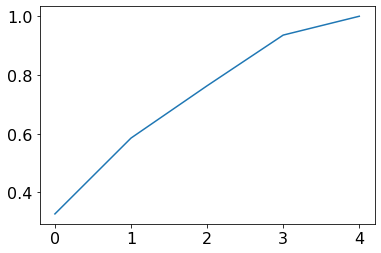

,0,1,2,3,4
0,-0.180053,0.488454,0.770650,0.641167,-0.155430
1,-0.502753,0.019558,0.673025,0.365708,0.261227
2,0.180762,-1.007790,0.235197,-0.098068,0.075857
3,0.964011,0.942952,-0.592283,0.295606,-0.445152
4,-0.467520,0.049980,0.476684,-0.711281,0.043932


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca_a_train = pca.fit(X_train_over, y_train_over)
print(pca_a_train.n_components_)
plt.plot(np.cumsum(pca_a_train.explained_variance_ratio_))
plt.show()

X_train_over_pca = pd.DataFrame(pca_a_train.transform(X_train_over))
n_pcs= pca_a_train.components_.shape[0]
most_important = [np.abs(pca_a_train.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['income', 'age', 'experience','house_ownership','car_ownership','city','state','current_job_years','current_house_years']
# most_important_names = [initial_feature_names[i] for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
# print(pd.DataFrame(pca.components_,columns=pca_a_train.transform(X_train_over).columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5']))
X_train_over_pca.head()

5


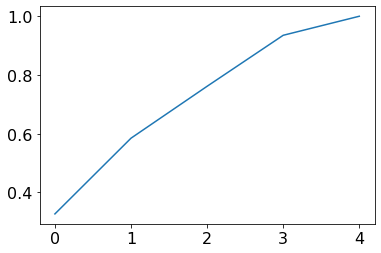

,0,1,2,3,4
0,-0.271166,-0.509735,-0.591441,0.404001,-0.240150
1,-0.878492,1.004389,-0.237803,0.824834,-0.068582
2,-0.505460,0.035810,0.986479,0.319278,-0.181553
3,-0.842168,-0.477366,0.111186,1.011667,-0.083520
4,0.145518,-0.988194,-0.767020,1.124773,0.653024


In [ ]:
pca = PCA(.95)
pca_a_test = pca.fit(X_test_over, y_test_over)
print(pca_a_test.n_components_)
plt.plot(np.cumsum(pca_a_test.explained_variance_ratio_))
plt.show()
X_test_over_pca = pd.DataFrame(pca_a_test.transform(X_test_over))
X_test_over_pca.head()

#KNeighborsClassifier

In [ ]:
from sklearn.model_selection import cross_val_score
train_cross_scores = []
test_cross_scores = []
classifier = KNeighborsClassifier()
classifier.fit(X_train_over_pca, y_train_over)
train_score = cross_val_score(classifier, X_train_over_pca, y_train_over, cv=5)
train_cross_scores.append(round(train_score.mean(),2))
test_score = cross_val_score(classifier, X_test_over_pca, y_test_over, cv=5)
test_cross_scores.append(round(test_score.mean(),2))

print(train_cross_scores)
print(test_cross_scores)

[0.92]
[0.91]


0.912060813103776


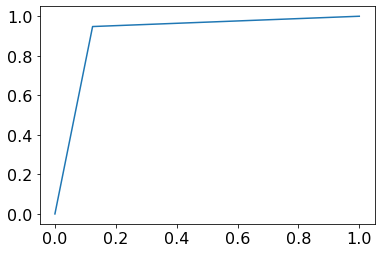

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
rf = KNeighborsClassifier()
rf.fit(X_train_over_pca, y_train_over)
rf_pred = cross_val_predict(rf, X_test_over_pca, y_test_over, cv=5)
print(roc_auc_score(y_test_over, rf_pred))
#Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test_over, rf_pred)
plt.plot(fpr, tpr)
plt.show()

In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train_over_pca, y_train_over)
lgb_train_score = cross_val_score(lgb_model, X_train_over_pca, y_train_over, cv=5)
lgb_test_score = cross_val_score(lgb_model, X_test_over_pca, y_test_over, cv=5)
print(round(lgb_train_score.mean(),2))
print(round(lgb_test_score.mean(),2))

0.78
0.78


#Random Forest

In [ ]:
from sklearn.model_selection import cross_val_score
train_cross_scores = []
test_cross_scores = []
classifier = RandomForestClassifier()
classifier.fit(X_train_over_pca, y_train_over)
train_score = cross_val_score(classifier, X_train_over_pca, y_train_over, cv=5)
train_cross_scores.append(round(train_score.mean(),2))
test_score = cross_val_score(classifier, X_test_over_pca, y_test_over, cv=5)
test_cross_scores.append(round(test_score.mean(),2))

print(train_cross_scores)
print(test_cross_scores)

[0.93]
[0.93]


0.9306689893893801


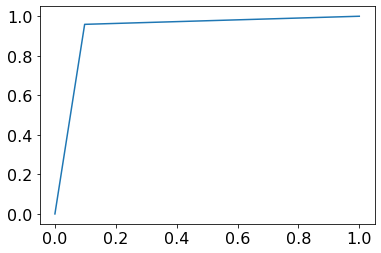

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
rf = RandomForestClassifier()
rf.fit(X_train_over_pca, y_train_over)
rf_pred = cross_val_predict(rf, X_test_over_pca, y_test_over, cv=5)
print(roc_auc_score(y_test_over, rf_pred))
#Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test_over, rf_pred)
plt.plot(fpr, tpr)
plt.show()

In [ ]:
y_pred = rf.predict(X_test_over_pca)

In [ ]:
accuracy_score(y_test_over, rf_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test_over,rf_pred),3)*100} %")

The accuracy of the model is 93.10000000000001 %


In [ ]:
train_probs = rf.predict_proba(X_train_over_pca)[:,1] 
# probs = rf.predict_proba(X_test_over_pca)[:, 1]
train_predictions = rf.predict(X_train_over_pca)

In [ ]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train_over, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test_over, rf_pred)}')

Train ROC AUC Score: 0.9732844327804172
Test ROC AUC  Score: 0.9306689893893801


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.5 Test: 0.91 Train: 0.92
Roc Baseline: 0.5 Test: 0.93 Train: 0.97


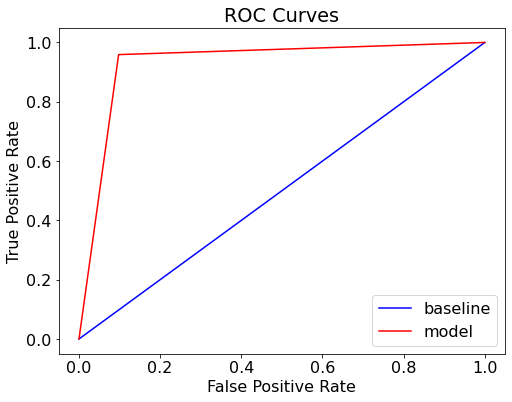

In [ ]:
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test_over,
                    [1 for _ in range(len(y_test_over))])
    baseline['precision'] = precision_score(y_test_over,
                    [1 for _ in range(len(y_test_over))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test_over, y_pred)
    results['precision'] = precision_score(y_test_over, y_pred)
    results['roc'] = roc_auc_score(y_test_over, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train_over,       train_predictions)
    train_results['precision'] = precision_score(y_train_over, train_predictions)
    train_results['roc'] = roc_auc_score(y_train_over, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
          print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test_over, [1 for _ in range(len(y_test_over))])
    model_fpr, model_tpr, _ = roc_curve(y_test_over, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
evaluate_model(rf_pred,rf_pred,train_predictions,train_probs)

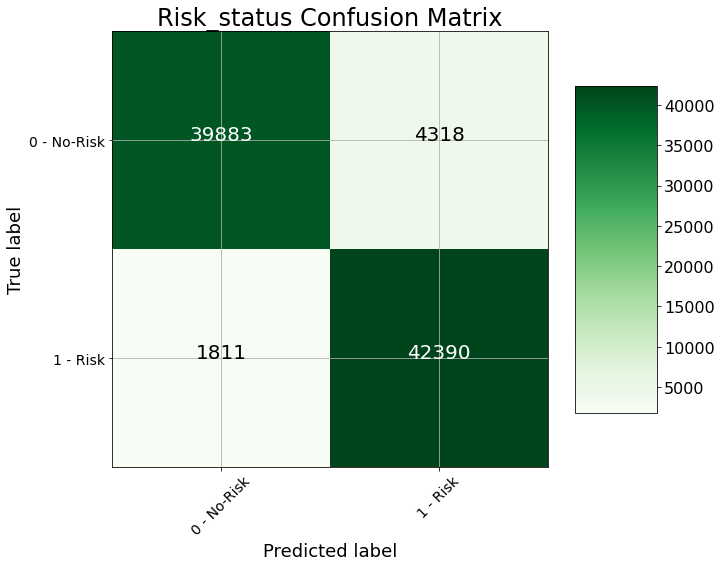

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test_over, rf_pred)
plot_confusion_matrix(cm, classes = ['0 - No-Risk', '1 - Risk'],
                      title = 'Risk_status Confusion Matrix')

In [ ]:
features_to_encode = X_train.columns[X_train.dtypes==object].tolist()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough")

In [ ]:
seed = 50

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=seed,
                      max_features='auto')

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['married', 'house_ownership',
                                                   'car_ownership',
                                                   'profession', 'city...
                 RandomForestClassifier(

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

In [ ]:
accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

The accuracy of the model is 87.7 %


In [ ]:
train_probs = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_predictions = pipe.predict(X_train)

In [ ]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.8581278330752429
Test ROC AUC  Score: 0.8361889943729937


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.12 Test: 0.0 Train: 0.0
Roc Baseline: 0.5 Test: 0.84 Train: 0.86


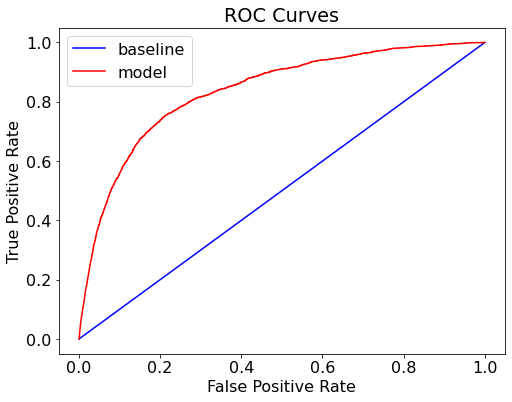

In [ ]:
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
          print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
evaluate_model(y_pred,probs,train_predictions,train_probs)

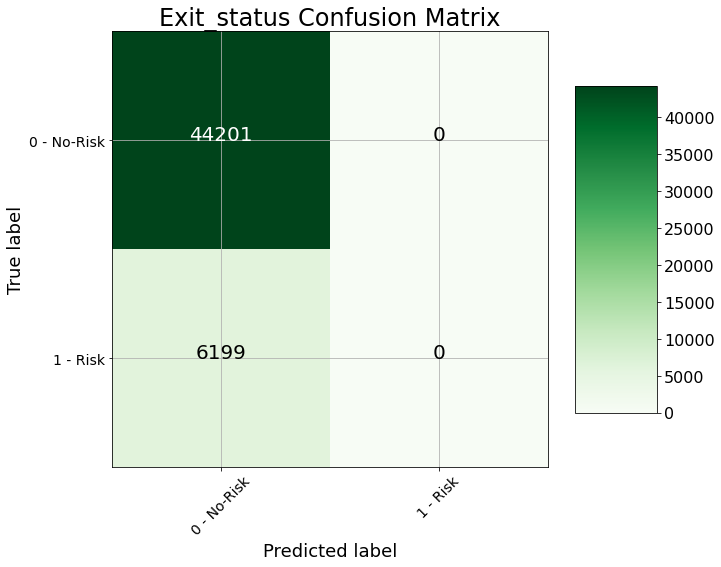

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - No-Risk', '1 - Risk'],
                      title = 'Exit_status Confusion Matrix')

In [ ]:
print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")

[4.34958549e-03 3.93389342e-03 2.25830980e-03 3.40041762e-03
 6.59997518e-03 7.09557166e-03 6.88974540e-03 4.45746364e-03
 3.65795154e-03 3.75843551e-03 4.45888920e-03 2.94143200e-03
 4.46639849e-03 5.49626966e-03 6.06820676e-03 2.80809512e-03
 2.81193522e-03 3.06939360e-03 3.55884321e-03 4.77660153e-03
 3.85550906e-03 4.59239506e-03 4.38386412e-03 6.54906437e-03
 3.04840781e-03 2.51649336e-03 4.31771637e-03 3.21661921e-03
 2.60826097e-03 6.15191087e-03 2.73455614e-03 4.73144304e-03
 4.97769987e-03 3.90823738e-03 2.96591897e-03 4.08055714e-03
 3.36041849e-03 3.53983592e-03 4.49116209e-03 3.83443664e-03
 3.47267367e-03 4.10894484e-03 2.67541978e-03 4.86837832e-03
 6.45669446e-03 7.08915154e-03 4.49690707e-03 3.76617480e-03
 4.65375802e-03 4.63327984e-03 6.68159418e-03 5.24541924e-03
 4.04873458e-03 5.78183033e-03 3.02857486e-03 5.25510343e-03
 3.96076857e-03 3.34248807e-03 1.21042787e-03 1.46242945e-03
 1.21055437e-03 1.95268657e-03 1.60850169e-04 1.21535289e-03
 3.88704805e-04 4.369562

In [ ]:
print(col_trans.fit_transform(X_train)[0,:])

  (0, 1)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 40)	1.0
  (0, 205)	1.0
  (0, 397)	1.0
  (0, 404)	8132252.0
  (0, 405)	72.0
  (0, 406)	7.0
  (0, 407)	6.0
  (0, 408)	13.0


In [ ]:
X_train.iloc[0,:] 

income                             8132252
age                                     72
experience                               7
married                             single
house_ownership                     rented
car_ownership                           no
profession             Mechanical_engineer
city                             Karaikudi
state                           Tamil_Nadu
current_job_years                        6
current_house_years                     13
Name: 13715, dtype: object

In [ ]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X_train, features_to_encode)

In [ ]:
feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

Feature: income                              Importance: 0.09021690539006222
Feature: age                                 Importance: 0.07645194534332254
Feature: experience                          Importance: 0.058295618268488336
Feature: current_job_years                   Importance: 0.05516203133039671
Feature: current_house_years                 Importance: 0.028442716612327626
Feature: state_Madhya_Pradesh                Importance: 0.01004095634316624
Feature: city_Bhubaneswar                    Importance: 0.007413222940665933
Feature: city_Ghaziabad                      Importance: 0.007306731383468651
Feature: state_West_Bengal                   Importance: 0.007206456531841018
Feature: state_Bihar                         Importance: 0.007163026546361718
Feature: state_Kerala                        Importance: 0.0071279189695479
Feature: car_ownership_no                    Importance: 0.007095571656801723
Feature: profession_Police_officer           Importance: 0.00708915154

In [ ]:
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [ ]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf_classifier.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 50,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier(oob_score=True)
# Create random search model and fit the data
rf_random = RandomizedSearchCV(
                        estimator = rf,
                        param_distributions = random_grid,
                        n_iter = 100, cv = 3,
                        verbose=2, random_state=seed, 
                        scoring='roc_auc')
rf_random.fit(X_train_encoded, y_train)
rf_random.best_params_
rf_random.best_params_

# Alternatively

In [ ]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_random = RandomizedSearchCV(
                estimator = rf,
                param_distributions = random_grid,
                n_iter = 50, cv = 3,
                verbose=1, random_state=seed,
                scoring='roc_auc')
pipe_random = make_pipeline(col_trans, rf_random)
pipe_random.fit(X_train, y_train)
rf_random.best_params_

In [ ]:
n_nodes = []
max_depths = []
for ind_tree in best_model.estimators_:
       n_nodes.append(ind_tree.tree_.node_count)
       max_depths.append(ind_tree.tree_.max_depth)
print(f'Average number of nodes {int(np.mean(n_nodes))}')   print(f'Average maximum depth {int(np.mean(max_depths))}') 

In [ ]:
best_model = rf_random.best_estimator_
pipe_best_model = make_pipeline(col_trans, best_model)
pipe_best_model.fit(X_train, y_train)
y_pred_best_model = pipe_best_model.predict(X_test)

In [ ]:
train_rf_predictions = pipe_best_model.predict(X_train)
train_rf_probs = pipe_best_model.predict_proba(X_train)[:, 1]
rf_probs = pipe_best_model.predict_proba(X_test)[:, 1]
# Plot ROC curve and check scores
evaluate_model(y_pred_best_model, rf_probs, train_rf_predictions, train_rf_probs)

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_model), classes = ['0 - N0-Risk', '1 - Risk'],
title = 'Exit_status Confusion Matrix')

# IV and WOE

In [ ]:
train_df = pd.read_csv("Training Data.csv",index_col=0)

In [ ]:
train_df["house_ownership"]=pd.factorize(train_df.house_ownership)[0]
train_df["city"]=pd.factorize(train_df.city)[0]
train_df["state"]=pd.factorize(train_df.state)[0]
train_df["married"]=pd.factorize(train_df.married)[0]
train_df["car_ownership"]=pd.factorize(train_df.car_ownership)[0]
train_df["profession"]=pd.factorize(train_df.profession)[0]

In [ ]:
train_df.head()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
Id,,,,,,,,,,,,
1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [ ]:
!pip install xverse

In [ ]:
from xverse.transformer import MonotonicBinning
X = train_df.drop(['risk_flag'], axis = 1)
y = train_df['risk_flag']
# clf = MonotonicBinning()
# clf.fit(X, y)

In [ ]:
print(clf.bins)
output_bins = clf.bins

{'income': array([  10310., 3318935., 6647587., 9999938.]), 'age': array([21., 40., 60., 79.]), 'experience': array([ 0.,  7., 14., 20.]), 'current_job_years': array([ 0.,  4.,  8., 14.]), 'current_house_years': array([10, 11, 12, 13, 14])}


In [ ]:
clf = MonotonicBinning(custom_binning=output_bins) #output_bins was created earlier

out_X = clf.transform(X)
out_X.head()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,bin
Id,,,,,,,,,,,,
1,"(10309.999, 3318935.0]","(20.999, 40.0]","(-0.001, 7.0]",single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,"(-0.001, 4.0]",13,Madhya_Pradesh
2,"(6647587.0, 9999938.0]","(20.999, 40.0]","(7.0, 14.0]",single,rented,no,Software_Developer,Parbhani,Maharashtra,"(8.0, 14.0]",13,Maharashtra
3,"(3318935.0, 6647587.0]","(60.0, 79.0]","(-0.001, 7.0]",married,rented,no,Technical_writer,Alappuzha,Kerala,"(-0.001, 4.0]",10,Kerala
4,"(3318935.0, 6647587.0]","(40.0, 60.0]","(-0.001, 7.0]",single,rented,yes,Software_Developer,Bhubaneswar,Odisha,"(-0.001, 4.0]",12,Odisha
5,"(3318935.0, 6647587.0]","(40.0, 60.0]","(7.0, 14.0]",single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,"(-0.001, 4.0]",14,Tamil_Nadu


In [ ]:
from xverse.transformer import WOE
clf = WOE()
clf.fit(X, y)
clf.woe_df  
clf.iv_df

,Variable_Name,Information_Value
2,city,0.199112
10,state,0.027023
9,profession,0.022923
5,experience,0.008539
6,house_ownership,0.007549
1,car_ownership,0.005495
8,married,0.004421
0,age,0.003255
4,current_job_years,0.002361
7,income,0.000882


In [ ]:
clf.transform(X)

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
Id,,,,,,,,,,,
1,0.006140,0.075832,0.114861,0.021480,0.023675,0.047242,-0.110598,-0.013474,0.263586,0.063024,-0.009008
2,0.032436,0.075832,-0.083022,0.021480,0.023675,0.047242,0.217328,-0.004671,-0.093602,-0.033012,-0.009008
3,-0.039570,-0.058147,0.114861,-0.205901,0.023675,0.047242,0.099720,0.070542,0.357982,0.063024,0.017990
4,-0.039570,-0.024006,0.114861,0.021480,0.023675,-0.116378,0.217328,1.238875,0.170056,0.063024,-0.011920
5,-0.039570,-0.024006,-0.083022,0.021480,0.023675,0.047242,-0.068552,-0.017382,-0.198245,0.063024,-0.015675
...,...,...,...,...,...,...,...,...,...,...,...
251996,0.032436,-0.024006,-0.083022,0.021480,0.023675,0.047242,-0.071770,-0.460269,0.046775,-0.040927,0.018214
251997,0.006140,0.075832,-0.083022,0.021480,0.023675,0.047242,0.246201,-0.013474,0.263586,-0.040927,0.018214
251998,-0.039570,-0.024006,0.114861,0.021480,0.023675,0.047242,-0.157442,-0.394466,-0.093602,-0.040927,-0.011920


In [ ]:
# output_woe_bins = clf.woe_bins #future transformation
# output_mono_bins = clf.mono_custom_binning  #future transformation
# clf = WOE(woe_bins=output_woe_bins, mono_custom_binning=output_mono_bins) #output_bins was created earlier
# out_X = clf.transform(X)

BarCharts(bar_color='#058caa', bar_type='v', exclude_features=None,
          feature_names='all', fig_size=(8, 6), num_color='#ed8549',
          plot_metric='mean')

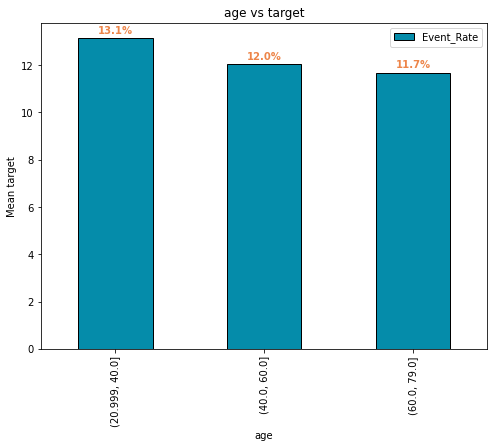

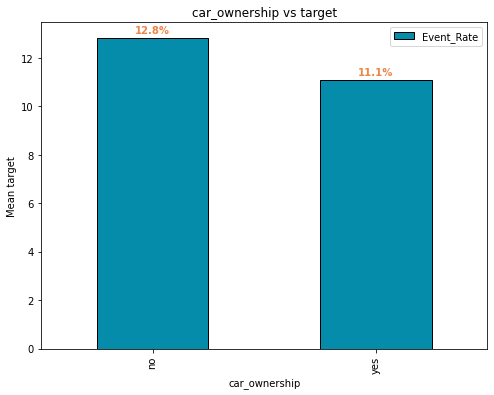

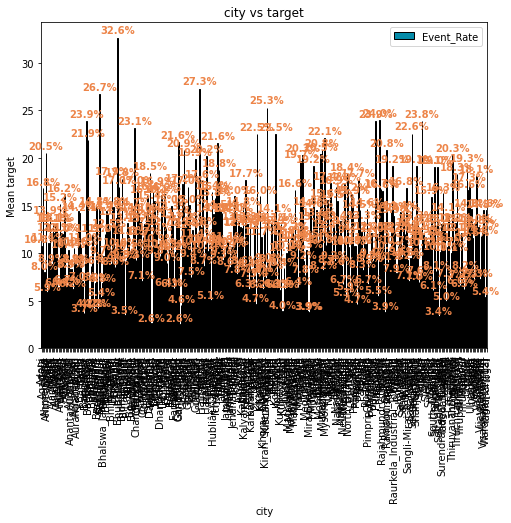

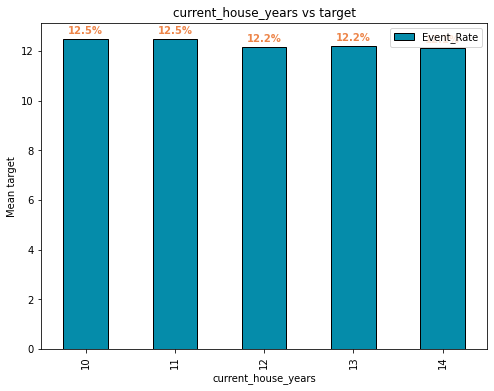

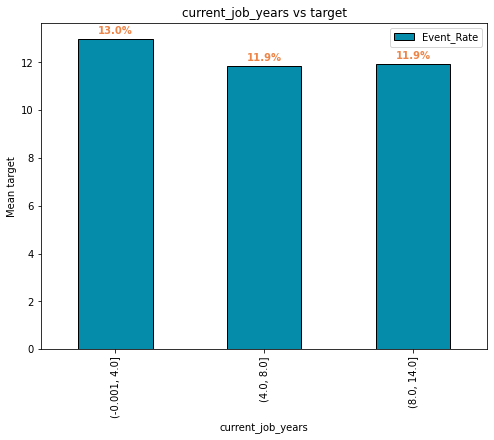

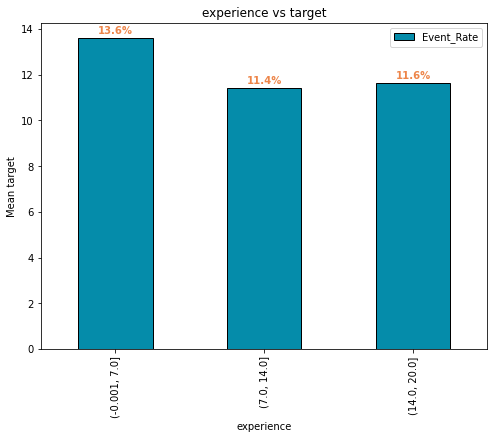

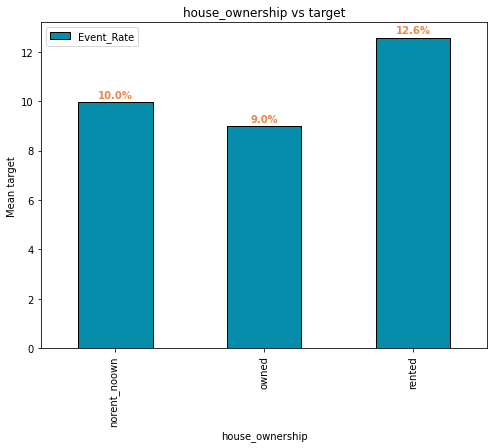

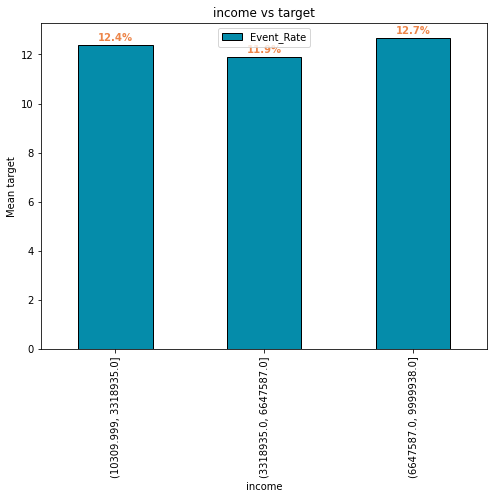

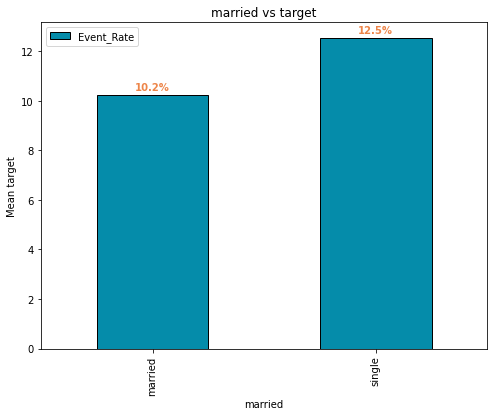

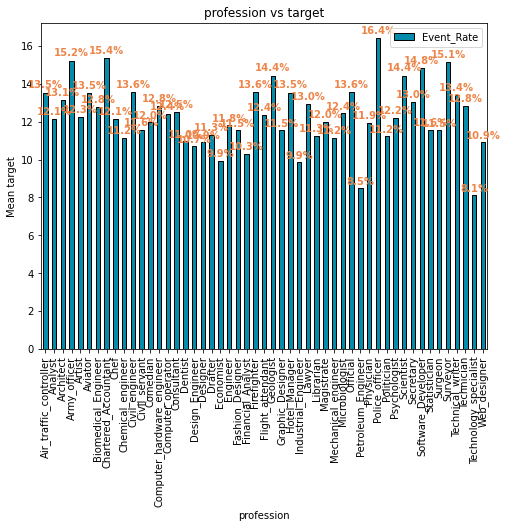

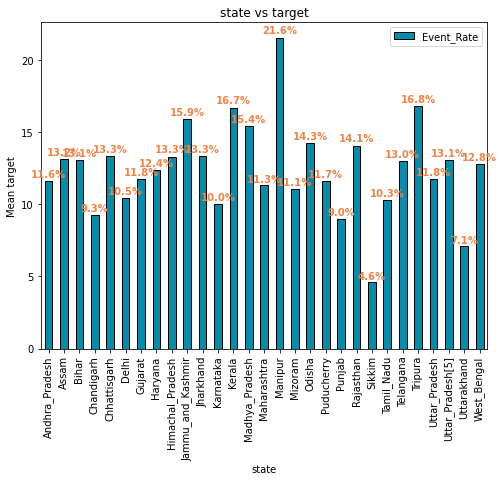

In [ ]:
woe_df = clf.woe_df
from xverse.graph import BarCharts
clf = BarCharts(bar_type='v')
clf.plot(woe_df)

In [ ]:
from xverse.ensemble import VotingSelector
clf = VotingSelector()
clf.fit(X, y)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=5,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [ ]:
clf.feature_importances_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One
0,city,0.199112,0.170382,0.000000e+00,0.153012,236.310486,2.001003e-01
1,state,0.027023,0.093621,0.000000e+00,0.113312,10.807366,4.087347e-03
2,profession,0.022923,0.135403,0.000000e+00,0.129429,40.046121,1.875612e-01
3,experience,0.008539,0.090050,-2.852066e-12,0.104433,53.653967,-2.146386e-03
4,house_ownership,0.007549,0.011769,0.000000e+00,0.011217,11.829118,1.618980e-01
5,car_ownership,0.005495,0.019016,0.000000e+00,0.014595,43.906031,1.535414e-01
6,married,0.004421,0.011937,0.000000e+00,0.010821,11.445289,1.624956e-01
7,age,0.003255,0.144870,-1.359563e-11,0.137797,20.782509,-1.489966e-03
8,current_job_years,0.002361,0.079866,-1.729688e-12,0.098503,10.849088,-2.948539e-03
9,income,0.000882,0.180390,-3.307271e-07,0.137917,0.400449,-3.900977e-09


In [ ]:
clf.feature_votes_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One,Votes
0,city,1,1,0,1,1,1,5
2,profession,1,1,0,1,1,1,5
7,age,0,1,1,1,1,0,4
1,state,1,1,0,1,0,0,3
3,experience,1,0,1,0,1,0,3
9,income,0,1,1,1,0,0,3
4,house_ownership,1,0,0,0,0,1,2
5,car_ownership,0,0,0,0,1,1,2
6,married,0,0,0,0,0,1,1
8,current_job_years,0,0,1,0,0,0,1


# New Prediction

In [ ]:
train_df = pd.read_csv("Training Data.csv",index_col=0)
train_df["house_ownership"]=pd.factorize(train_df.house_ownership)[0]
train_df["city"]=pd.factorize(train_df.city)[0]
train_df["state"]=pd.factorize(train_df.state)[0]
train_df["married"]=pd.factorize(train_df.married)[0]
train_df["car_ownership"]=pd.factorize(train_df.car_ownership)[0]
train_df["profession"]=pd.factorize(train_df.profession)[0]
X = train_df.drop(['risk_flag','current_house_years','current_job_years','married','car_ownership','house_ownership'], axis = 1)
y = train_df['risk_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_test = X_train.copy(), X_test.copy()
X_train_scaled = pd.DataFrame(RobustScaler().fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(RobustScaler().fit_transform(X_test), columns=X_test.columns)
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train_scaled, y_train)
# print(Counter(y_train_over))
oversample = SMOTE()
X_test_over, y_test_over = oversample.fit_resample(X_test_scaled, y_test)
# print(Counter(y_test_over))
from sklearn.decomposition import PCA
pca = PCA(.95)
pca_a_train = pca.fit(X_train_over, y_train_over)
# print(pca_a_train.n_components_)
# plt.plot(np.cumsum(pca_a_train.explained_variance_ratio_))
# plt.show()

X_train_over_pca = pd.DataFrame(pca_a_train.transform(X_train_over))
n_pcs= pca_a_train.components_.shape[0]
most_important = [np.abs(pca_a_train.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['income', 'age', 'experience','house_ownership','car_ownership','city','state','current_job_years','current_house_years']
# most_important_names = [initial_feature_names[i] for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
# print(pd.DataFrame(pca.components_,columns=pca_a_train.transform(X_train_over).columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5']))
# X_train_over_pca.head()
pca = PCA(.95)
pca_a_test = pca.fit(X_test_over, y_test_over)
# print(pca_a_test.n_components_)
# plt.plot(np.cumsum(pca_a_test.explained_variance_ratio_))
# plt.show()
X_test_over_pca = pd.DataFrame(pca_a_test.transform(X_test_over))
# X_test_over_pca.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
from sklearn.model_selection import cross_val_score
train_cross_scores = []
test_cross_scores = []
classifier = RandomForestClassifier()
classifier.fit(X_train_over_pca, y_train_over)
train_score = cross_val_score(classifier, X_train_over_pca, y_train_over, cv=5)
train_cross_scores.append(round(train_score.mean(),2))
test_score = cross_val_score(classifier, X_test_over_pca, y_test_over, cv=5)
test_cross_scores.append(round(test_score.mean(),2))

print(train_cross_scores)
print(test_cross_scores)

[0.93]
[0.94]


0.9345376801429832


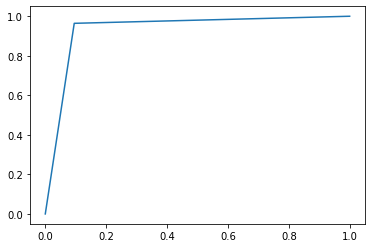

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
rf = RandomForestClassifier()
rf.fit(X_train_over_pca, y_train_over)
rf_pred = cross_val_predict(rf, X_test_over_pca, y_test_over, cv=5)
print(roc_auc_score(y_test_over, rf_pred))
#Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test_over, rf_pred)
plt.plot(fpr, tpr)
plt.show()

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lg = SVC(gamma='auto',kernel='rbf')
lg.fit(X_train_over_pca, y_train_over)
lg_pred = cross_val_predict(lg, X_test_over_pca, y_test_over, cv=5)
print(roc_auc_score(y_test_over, lg_pred))
#Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test_over, lg_pred)
plt.plot(fpr, tpr)
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}

In [ ]:
seed = 50
rf = RandomForestClassifier(oob_score=True)
# Create random search model and fit the data
rf_random = RandomizedSearchCV(
                        estimator = rf,
                        param_distributions = random_grid,
                        n_iter = 100, cv = 5,
                        verbose=2, random_state=seed, 
                        scoring='roc_auc',n_jobs=-1)
rf_random.fit(X_train_over_pca, y_train_over)
rf_random.best_params_

In [ ]:
train_df = pd.read_csv("Training Data.csv",index_col=0)
train_df["house_ownership"]=pd.factorize(train_df.house_ownership)[0]
train_df["city"]=pd.factorize(train_df.city)[0]
train_df["state"]=pd.factorize(train_df.state)[0]
train_df["married"]=pd.factorize(train_df.married)[0]
train_df["car_ownership"]=pd.factorize(train_df.car_ownership)[0]
train_df["profession"]=pd.factorize(train_df.profession)[0]
X = train_df.drop(['risk_flag'], axis = 1)
y = train_df['risk_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_test = X_train.copy(), X_test.copy()
X_train_scaled = pd.DataFrame(RobustScaler().fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(RobustScaler().fit_transform(X_test), columns=X_test.columns)
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train_scaled, y_train)
# print(Counter(y_train_over))
oversample = SMOTE()
X_test_over, y_test_over = oversample.fit_resample(X_test_scaled, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
X_train_new = pd.DataFrame(X_train_over,columns=['income', 'age', 'experience','married','house_ownership','car_ownership','profession','city','state','current_job_years','current_house_years'])
y_train_new = pd.DataFrame(y_train_over,columns=['risk_flag'])

In [ ]:
from xverse.ensemble import VotingSelector
clf = VotingSelector()
clf.fit(X_train_scaled, y_train)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=5,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [ ]:
clf.feature_votes_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One,Votes
5,age,0,1,1,1,1,1,5
2,car_ownership,1,0,1,0,1,1,4
0,city,1,1,0,1,0,0,3
1,income,1,1,0,1,0,0,3
4,state,1,1,0,1,0,0,3
7,house_ownership,0,0,1,0,1,1,3
8,experience,0,0,1,0,1,1,3
10,married,0,0,1,0,1,1,3
9,profession,0,1,0,1,0,0,2
3,current_house_years,1,0,0,0,0,0,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



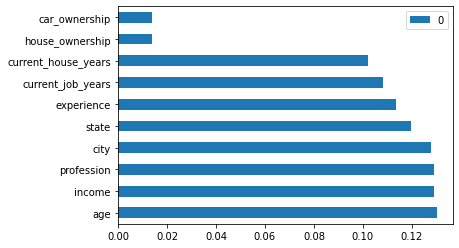

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
fi = ExtraTreesClassifier()
fi_a = fi.fit(X_train_new, y_train_new)
df_fi_a = pd.DataFrame(fi_a.feature_importances_,index=X_train_new.columns)
df_fi_a.nlargest(10,df_fi_a.columns).plot(kind='barh')
plt.show()

In [ ]:
# to remove: married, car_ownership, house_ownership,current_house_years,current_job_years

# Best Till Now

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/TrainingData.csv",index_col=0)

In [ ]:
# %pip install wandb -q
# import wandb

     |████████████████████████████████| 2.1MB 9.0MB/s 
     |████████████████████████████████| 133kB 37.1MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 163kB 29.6MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 


In [ ]:

train_df["house_ownership"]=pd.factorize(train_df.house_ownership)[0]
train_df["city"]=pd.factorize(train_df.city)[0]
train_df["state"]=pd.factorize(train_df.state)[0]
train_df["married"]=pd.factorize(train_df.married)[0]
train_df["car_ownership"]=pd.factorize(train_df.car_ownership)[0]
train_df["profession"]=pd.factorize(train_df.profession)[0]
X = train_df.drop(['risk_flag','married', 'car_ownership', 'house_ownership','current_house_years','current_job_years'], axis = 1)
y = train_df['risk_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_test = X_train.copy(), X_test.copy()
X_train_scaled = pd.DataFrame(RobustScaler().fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(RobustScaler().fit_transform(X_test), columns=X_test.columns)
oversample = SMOTE(random_state=12, ratio = 1.0)
X_train_over, y_train_over = oversample.fit_resample(X_train_scaled, y_train)

oversample = SMOTE(random_state=12, ratio = 1.0)
X_test_over, y_test_over = oversample.fit_resample(X_test_scaled, y_test)
from sklearn.decomposition import PCA
pca = PCA(.95)
pca_a_train = pca.fit(X_train_over, y_train_over)


X_train_over_pca = pd.DataFrame(pca_a_train.transform(X_train_over))
n_pcs= pca_a_train.components_.shape[0]
most_important = [np.abs(pca_a_train.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['income', 'age', 'experience','profession','city','state']

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]



dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}


df = pd.DataFrame(sorted(dic.items()))

X_train_over_pca.head()
pca = PCA(.95)
pca_a_test = pca.fit(X_test_over, y_test_over)
print(pca_a_test.n_components_)

X_test_over_pca = pd.DataFrame(pca_a_test.transform(X_test_over))
X_test_over_pca.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



6


,0,1,2,3,4,5
0,1.269264,0.482330,0.290659,-0.448211,-0.637905,0.183789
1,0.907627,0.819611,0.227195,-0.738870,0.057914,0.368347
2,0.282814,0.660907,-0.383633,0.116269,1.242041,0.398168
3,-0.211324,0.777724,-0.371409,-0.942922,-0.371980,0.248687
4,-0.393356,-0.588590,0.653431,-1.431778,-0.182085,-0.232784


In [ ]:
X

,income,age,experience,profession,city,state
Id,,,,,,
1,1303835,23,3,0,0,0
2,7574516,40,10,1,1,1
3,3991815,66,4,2,2,2
4,6256451,41,2,1,3,3
5,5768871,47,11,3,4,4
...,...,...,...,...,...,...
251996,8154883,43,13,46,220,10
251997,2843572,26,10,45,0,0
251998,4522448,46,7,16,106,1


In [ ]:
from sklearn.model_selection import cross_val_score
train_cross_scores = []
test_cross_scores = []
classifier = RandomForestClassifier()
classifier.fit(X_train_over_pca, y_train_over)
train_score = cross_val_score(classifier, X_train_over_pca, y_train_over, cv=5)
train_cross_scores.append(round(train_score.mean(),2))
test_score = cross_val_score(classifier, X_test_over_pca, y_test_over, cv=5)
test_cross_scores.append(round(test_score.mean(),2))

print(train_cross_scores)
print(test_cross_scores)

[0.93]
[0.94]


In [ ]:
classifier.get_params(deep=True)

In [ ]:
# wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# sweep_config = {
#     'method': 'random', #grid, random
#     'metric': {
#       'name': 'accuracy',
#       'goal': 'maximize'   
#     },
#     'parameters': {
#         'n_estimators': {
#             'values': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#         },
#         'max_features': {
#             'values': ['auto', 'sqrt']
#         },
#         'max_depth': {
#             'values': [int(x) for x in np.linspace(10, 110, num = 11)]
#         },
#         'min_samples_split': {
#             'values': [2, 5, 10]
#         },
#         'min_samples_leaf': {
#             'values': [1, 2, 5, 10]
#         }
#     }
# }

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project="hackathon")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: muk6jpay
Sweep URL: https://wandb.ai/26tanishabanik/hackathon/sweeps/muk6jpay


In [ ]:
# from sklearn.model_selection import cross_val_score
# train_cross_scores = []
# test_cross_scores = []
# def train():
#     # Default values for hyper-parameters we're going to sweep over
#     config_defaults = {
#         'max_depth': None,
#         'max_features': 'auto',
#         'min_samples_leaf': 1,
#         'min_samples_split': 2,
#         'n_estimators': 100,
#         'seed': 42
#       }

#     # Initialize a new wandb run
#     wandb.init(config=config_defaults)
    
#     # Config is a variable that holds and saves hyperparameters and inputs
#     config = wandb.config
#     if config.max_features == 'auto':
#       classifier = RandomForestClassifier(max_depth=config.max_depth, max_features="auto", min_samples_leaf=config.min_samples_leaf, min_samples_split=config.min_samples_split, n_estimators=config.n_estimators)
#     elif config.max_features == 'sqrt':
#       classifier = RandomForestClassifier(max_depth=config.max_depth, max_features="sqrt", min_samples_leaf=config.min_samples_leaf, min_samples_split=config.min_samples_split, n_estimators=config.n_estimators)
    
#     classifier.fit(X_train_over_pca, y_train_over)
#     train_score = cross_val_score(classifier, X_train_over_pca, y_train_over, cv=5)
#     train_cross_scores.append(round(train_score.mean(),2))
#     test_score = cross_val_score(classifier, X_test_over_pca, y_test_over, cv=5)
#     test_cross_scores.append(round(test_score.mean(),2))

#     print(train_cross_scores)
#     print(test_cross_scores)
    


In [ ]:
# wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: ph2ws96z with config:
wandb: 	max_depth: 100
wandb: 	max_features: sqrt
wandb: 	min_samples_leaf: 10
wandb: 	min_samples_split: 10
wandb: 	n_estimators: 1400


wandb: Ctrl + C detected. Stopping sweep.


0.9372186149634624


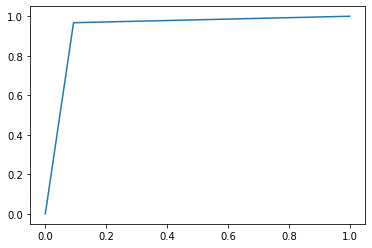

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
rf = RandomForestClassifier()
rf.fit(X_train_over_pca, y_train_over)
rf_pred = cross_val_predict(rf, X_test_over_pca, y_test_over, cv=5)
print(roc_auc_score(y_test_over, rf_pred))
#Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test_over, rf_pred)
plt.plot(fpr, tpr)
plt.show()a

In [ ]:
train_score

array([0.93191652, 0.93385275, 0.93335784, 0.93419211, 0.93526675])

In [ ]:
test_score

array([0.92211979, 0.94185849, 0.9388009 , 0.94225113, 0.93936652])

In [ ]:
print(cross_val_score(classifier, X_test_over_pca, y_test_over, cv=5))
print(recall_score(y_test_over, rf_pred))

[0.89315476 0.89335317 0.89305556 0.89196429 0.89186508]
0.4629778996612357


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_over, rf_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     44201
           1       0.91      0.97      0.94     44201

    accuracy                           0.94     88402
   macro avg       0.94      0.94      0.94     88402
weighted avg       0.94      0.94      0.94     88402



# Latest prediction

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/TrainingData.csv",index_col=0)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

In [ ]:
accuracy_score(y_test_over, rf_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test_over,rf_pred),3)*100} %")

The accuracy of the model is 93.7 %


In [ ]:
train_probs = rf.predict_proba(X_train_over_pca)[:,1] 
# probs = rf.predict_proba(X_test_over_pca)[:, 1]
train_predictions = rf.predict(X_train_over_pca)

In [ ]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train_over, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test_over, rf_pred)}')

Train ROC AUC Score: 0.9731586746572902
Test ROC AUC  Score: 0.9372186149634624


Recall Baseline: 1.0 Test: 0.97 Train: 1.0
Precision Baseline: 0.5 Test: 0.91 Train: 0.92
Roc Baseline: 0.5 Test: 0.94 Train: 0.97


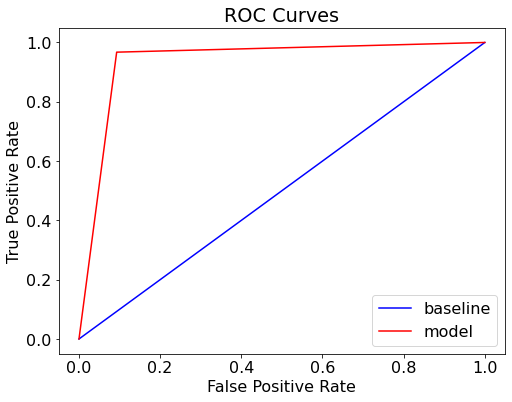

In [ ]:
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test_over,
                    [1 for _ in range(len(y_test_over))])
    baseline['precision'] = precision_score(y_test_over,
                    [1 for _ in range(len(y_test_over))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test_over, y_pred)
    results['precision'] = precision_score(y_test_over, y_pred)
    results['roc'] = roc_auc_score(y_test_over, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train_over,       train_predictions)
    train_results['precision'] = precision_score(y_train_over, train_predictions)
    train_results['roc'] = roc_auc_score(y_train_over, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
          print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test_over, [1 for _ in range(len(y_test_over))])
    model_fpr, model_tpr, _ = roc_curve(y_test_over, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
evaluate_model(rf_pred,rf_pred,train_predictions,train_probs)

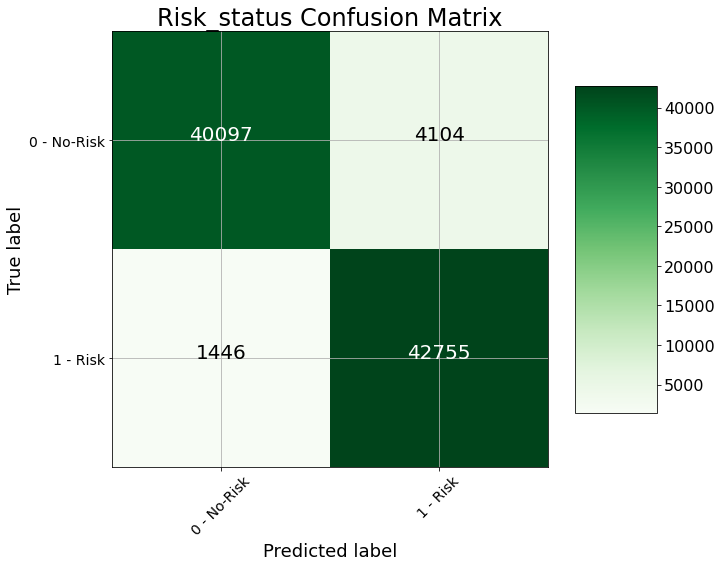

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test_over, rf_pred)
plot_confusion_matrix(cm, classes = ['0 - No-Risk', '1 - Risk'],
                      title = 'Risk_status Confusion Matrix')